In [1]:
%%bash
!(stat -t /usr/local/lib/*/dist-packages/google/colab > /dev/null 2>&1) && exit
rm -rf 6864-hw3
git clone https://github.com/mit-6864/hw3.git

Cloning into 'hw3'...


In [2]:
!pip install transformers
!pip install langdetect
!pip install datasets
from datasets import load_dataset

dataset = load_dataset("tweet_eval", "irony")

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993225 sha256=57a466f18d01b2c56f9c4d41bce4500e156ceb8fc2edea545beb02eb638ae6f6
  Stored in directory: /root/.cache/pip/wheels/95/03/7d/59ea870c70ce4e5a370638b5462a7711ab78fba2f655d05106
Successfully built langdetect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 521.2/521.2 kB 5.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 13.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 18.8 MB/s eta 0:00:00


Extracting data files:   0%|          | 0/6 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/2862 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/784 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/955 [00:00<?, ? examples/s]

In [3]:
import sys
import os
sys.path.append("/content/hw3")
import csv
import itertools as it
import numpy as np
import sklearn.decomposition
np.random.seed(0)
from tqdm import tqdm

import lab_util
import random

In [4]:
from langdetect import detect
import re

def remove_emojis(data):
    emoj = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642"
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def clean_csv(csv_file):
  with open(csv_file) as reader:
    csvreader = csv.reader(reader)
    next(csvreader)
    rows = list(csvreader)
    random_tweets = random.sample(rows, 3000)

  sampling_pool = []
  for row in random_tweets:
    try:
      if len(row) >= 3 and detect(row[2]) == 'en':
        sampling_pool.append(row)
    except:
      pass

  sampling_pool = random.sample(sampling_pool, 300)
  cleaned_samples = []
  for sample in sampling_pool:
    split_tweet = sample[2].split()
    cleaned_words = []
    for word in split_tweet:
      if 'https:' not in word and '@' not in word and (word.isalpha() or word[0] == '#'):
        cleaned_words.append(remove_emojis(word))
    cleaned_samples.append((' '.join(cleaned_words), 1))
  return cleaned_samples

In [5]:
sampling_pool = random.sample(dataset['train']['text'], 900)
cleaned_samples_nonpolitical = []
for sample in sampling_pool:
  sample = remove_emojis(sample)
  split_tweet = sample.split()
  # print(split_tweet)
  cleaned_words = []
  for word in split_tweet:
    word = word.replace('.','')
    if 'https:' not in word and '@' not in word and len(word) >= 3 and (word.isalpha() or word[0] == '#'):
      cleaned_words.append(remove_emojis(word))
  cleaned_samples_nonpolitical.append((' '.join(cleaned_words), 0))

In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
cleaned_joe = clean_csv('/content/drive/MyDrive/NLP-Political-Polarity/hashtag_joebiden.csv')
cleaned_donald = clean_csv('/content/drive/MyDrive/NLP-Political-Polarity/hashtag_donaldtrump.csv')
cleaned_aus = clean_csv('/content/drive/MyDrive/NLP-Political-Polarity/auspol2019.csv')

In [9]:
cleaned_data = cleaned_joe.copy()
cleaned_data.extend(cleaned_donald)
cleaned_data.extend(cleaned_samples_nonpolitical)
# cleaned_data.extend(cleaned_scrape)
cleaned_data.extend(cleaned_aus)
np.random.seed(0)
np.random.shuffle(cleaned_data)
tweets, labels = zip(*cleaned_data)

In [10]:
def remove_empty(tweet, label):
  new_tweets = []
  new_labels = []
  for i in range(len(tweet)):
    if len(tweet[i]):
      new_tweets.append(tweet[i])
      new_labels.append(label[i])
  return new_tweets, new_labels

In [11]:
train_tweets, train_labels = tweets[:1400], labels[:1400]
val_tweets, val_labels = tweets[1400:1600], labels[1400:1600]
test_tweets, test_labels = tweets[1600:], labels[1600:]

In [12]:
train_tweets, train_labels = remove_empty(train_tweets, train_labels)
val_tweets, val_labels = remove_empty(val_tweets, val_labels)
test_tweets, test_labels = remove_empty(test_tweets, test_labels)

In [13]:
# from transformers import AutoTokenizer
from transformers import DistilBertTokenizer
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-cased')

tokenizer_config.json:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/465 [00:00<?, ?B/s]

In [14]:
all_tweets = train_tweets + val_tweets + test_tweets
hashtagged_words = set()
for tweet in all_tweets:
  words = tweet.split()
  for word in words:
    if word[0] == '#':
      hashtagged_words.add(word)
hashtagged_words = list(hashtagged_words)

In [15]:
num_added_toks = tokenizer.add_tokens(hashtagged_words)
print('We have added', num_added_toks, 'hashtagged word tokens')
# model.resize_token_embeddings(len(tokenizer))

We have added 2028 hashtagged word tokens


In [23]:
print(tokenizer.get_vocab())

{'[PAD]': 0, '[unused1]': 1, '[unused2]': 2, '[unused3]': 3, '[unused4]': 4, '[unused5]': 5, '[unused6]': 6, '[unused7]': 7, '[unused8]': 8, '[unused9]': 9, '[unused10]': 10, '[unused11]': 11, '[unused12]': 12, '[unused13]': 13, '[unused14]': 14, '[unused15]': 15, '[unused16]': 16, '[unused17]': 17, '[unused18]': 18, '[unused19]': 19, '[unused20]': 20, '[unused21]': 21, '[unused22]': 22, '[unused23]': 23, '[unused24]': 24, '[unused25]': 25, '[unused26]': 26, '[unused27]': 27, '[unused28]': 28, '[unused29]': 29, '[unused30]': 30, '[unused31]': 31, '[unused32]': 32, '[unused33]': 33, '[unused34]': 34, '[unused35]': 35, '[unused36]': 36, '[unused37]': 37, '[unused38]': 38, '[unused39]': 39, '[unused40]': 40, '[unused41]': 41, '[unused42]': 42, '[unused43]': 43, '[unused44]': 44, '[unused45]': 45, '[unused46]': 46, '[unused47]': 47, '[unused48]': 48, '[unused49]': 49, '[unused50]': 50, '[unused51]': 51, '[unused52]': 52, '[unused53]': 53, '[unused54]': 54, '[unused55]': 55, '[unused56]': 5

In [16]:
import torch
from torch.utils.data import TensorDataset
def tokenizer_function(input_data, labels):
  input_ids = []
  attention_masks = []
  for sent in input_data:
    this_encoding = tokenizer.encode_plus(sent, truncation=True, pad_to_max_length = True,max_length = 100,return_attention_mask = True,return_tensors = 'pt')
    # print(tokenizer.decode(this_encoding['input_ids'][0]))
    input_ids.append(this_encoding['input_ids'])
    # print(this_encoding)
    attention_masks.append( this_encoding['attention_mask'])
  input_ids = torch.cat(input_ids, dim=0)
  attention_masks = torch.cat(attention_masks, dim=0)
  labels = torch.tensor(labels)
  tokenized_data = TensorDataset(input_ids, attention_masks, labels)
  return tokenized_data

In [17]:
train_dataset = tokenizer_function(train_tweets, train_labels)
val_dataset = tokenizer_function(val_tweets, val_labels)
test_dataset = tokenizer_function(test_tweets, test_labels)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


# Baseline Model

In [18]:
from transformers import DistilBertForSequenceClassification, AdamW
from torch.utils.data import DataLoader
import torch.nn.functional as F
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
# device = torch.device('cpu')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2, output_attentions = False, output_hidden_states=False)
model.resize_token_embeddings(len(tokenizer))
model.to(device)

train_loader = DataLoader(train_dataset, batch_size=28, shuffle=True) #Feel free to experiment with batch sizes
val_loader = DataLoader(val_dataset, batch_size=28, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=28, shuffle=False)

model.safetensors:   0%|          | 0.00/263M [00:00<?, ?B/s]

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['classifier.weight', 'pre_classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [19]:
optimizer = AdamW(model.parameters(),
                lr = 2e-5, # args.learning_rate - default is 5e-5.
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
              )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [20]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [29]:
print(model.get_input_embeddings())

Embedding(31082, 768)


In [30]:
params = list(model.named_parameters())

print('The BERT model has {:} different named parameters.\n'.format(len(params)))

print('==== Embedding Layer ====\n')

for p in params[0:5]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== First Transformer ====\n')

for p in params[5:21]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

print('\n==== Output Layer ====\n')

for p in params[-4:]:
    print("{:<55} {:>12}".format(p[0], str(tuple(p[1].size()))))

The BERT model has 104 different named parameters.

==== Embedding Layer ====

distilbert.embeddings.word_embeddings.weight            (31082, 768)
distilbert.embeddings.position_embeddings.weight          (512, 768)
distilbert.embeddings.LayerNorm.weight                        (768,)
distilbert.embeddings.LayerNorm.bias                          (768,)
distilbert.transformer.layer.0.attention.q_lin.weight     (768, 768)

==== First Transformer ====

distilbert.transformer.layer.0.attention.q_lin.bias           (768,)
distilbert.transformer.layer.0.attention.k_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.k_lin.bias           (768,)
distilbert.transformer.layer.0.attention.v_lin.weight     (768, 768)
distilbert.transformer.layer.0.attention.v_lin.bias           (768,)
distilbert.transformer.layer.0.attention.out_lin.weight   (768, 768)
distilbert.transformer.layer.0.attention.out_lin.bias         (768,)
distilbert.transformer.layer.0.sa_layer_norm.weight           (

In [21]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))

In [22]:
total_t0 = time.time()
losses = []
for epoch in tqdm(range(10)):
  total_train_loss = 0
  model.train()
  for step, batch in enumerate(train_loader):

    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    model.zero_grad()
    outputs = model(b_input_ids,
                            attention_mask=b_input_mask,
                            labels=b_labels)
    loss = outputs.loss
    total_train_loss += loss
    loss.backward()
    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
    optimizer.step()
    if(step %10 == 0):
      print(loss)

  avg_train_loss = total_train_loss / len(train_loader)
  losses.append(avg_train_loss)
  print("")
  print("  Average training loss: {0:.2f}".format(avg_train_loss))

  print("")
  print("Running Validation...")

  t0 = time.time()

  # Put the model in evaluation mode-
  model.eval()

  # Tracking variables
  total_eval_accuracy = 0
  total_eval_loss = 0
  nb_eval_steps = 0

    # Evaluate data for one epoch
  for batch in val_loader:
      #
      # `batch` contains three pytorch tensors:
      #   [0]: input ids
      #   [1]: attention masks
      #   [2]: labels
      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)

      with torch.no_grad():

          outputs = model(b_input_ids,
                                  attention_mask=b_input_mask,
                                  labels=b_labels)

      # Accumulate the validation loss.
      loss = outputs.loss
      logits = outputs.logits
      total_eval_loss += loss.item()

      # Move logits and labels to CPU
      logits = logits.detach().cpu().numpy()
      label_ids = b_labels.to('cpu').numpy()

      # Calculate the accuracy for this batch of test sentences, and
      # accumulate it over all batches.
      total_eval_accuracy += flat_accuracy(logits, label_ids)


  # Report the final accuracy for this validation run.
  avg_val_accuracy = total_eval_accuracy / len(val_loader)
  print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

  # Calculate the average loss over all of the batches.
  avg_val_loss = total_eval_loss / len(val_loader)

  # Measure how long the validation run took.
  validation_time = format_time(time.time() - t0)

  print("  Validation Loss: {0:.2f}".format(avg_val_loss))
  print("  Validation took: {:}".format(validation_time))

print("")
print("Training complete!")

print("Total training took {:}".format(format_time(time.time()-total_t0)))

  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.6886, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6627, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5331, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3375, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3528, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.49

Running Validation...


 10%|█         | 1/10 [00:13<02:04, 13.87s/it]

  Accuracy: 0.92
  Validation Loss: 0.22
  Validation took: 0:00:01
tensor(0.2883, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1649, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2210, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1426, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2738, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.16

Running Validation...


 20%|██        | 2/10 [00:25<01:38, 12.34s/it]

  Accuracy: 0.91
  Validation Loss: 0.15
  Validation took: 0:00:01
tensor(0.0273, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0178, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0129, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2466, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0326, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.07

Running Validation...


 30%|███       | 3/10 [00:36<01:23, 11.95s/it]

  Accuracy: 0.92
  Validation Loss: 0.31
  Validation took: 0:00:01
tensor(0.0089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1205, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0029, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0520, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.03

Running Validation...


 40%|████      | 4/10 [00:48<01:11, 11.85s/it]

  Accuracy: 0.97
  Validation Loss: 0.10
  Validation took: 0:00:01
tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 50%|█████     | 5/10 [01:00<00:59, 11.94s/it]

  Accuracy: 0.97
  Validation Loss: 0.15
  Validation took: 0:00:01
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 60%|██████    | 6/10 [01:12<00:48, 12.11s/it]

  Accuracy: 0.96
  Validation Loss: 0.25
  Validation took: 0:00:01
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0904, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:25<00:36, 12.33s/it]

  Accuracy: 0.97
  Validation Loss: 0.16
  Validation took: 0:00:01
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:38<00:25, 12.65s/it]

  Accuracy: 0.98
  Validation Loss: 0.12
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 90%|█████████ | 9/10 [01:52<00:12, 12.95s/it]

  Accuracy: 0.94
  Validation Loss: 0.36
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0196, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [02:05<00:00, 12.59s/it]

  Accuracy: 0.96
  Validation Loss: 0.20
  Validation took: 0:00:01

Training complete!
Total training took 0:02:06


In [23]:
print('Predicting labels for {:,} test tweets...'.format(len(test_tweets)))

# Put model in evaluation mode
model.eval()

# Tracking variables
predictions , true_labels = [], []

# Predict
for batch in test_loader:

  # Unpack the inputs from our dataloader
  b_input_ids = batch[0].to(device)
  b_input_mask = batch[1].to(device)
  b_labels = batch[2].to(device)
  # Telling the model not to compute or store gradients, saving memory and
  # speeding up prediction
  with torch.no_grad():
      # Forward pass, calculate logit predictions
      outputs = model(b_input_ids,
                      attention_mask=b_input_mask)
  logits = outputs[0]

  # Move logits and labels to CPU
  logits = logits.detach().cpu().numpy()
  label_ids = b_labels.to('cpu').numpy()

  # Store predictions and true labels
  predictions.extend(logits)
  true_labels.extend(label_ids)
print('Final Accuracy: {0}'.format(flat_accuracy(np.asarray(predictions), np.asarray(true_labels))))

print('    DONE.')

Predicting labels for 200 test tweets...
Final Accuracy: 0.97
    DONE.


In [24]:
losses = [l.item() for l in losses]

Text(0, 0.5, 'Average Training Loss')

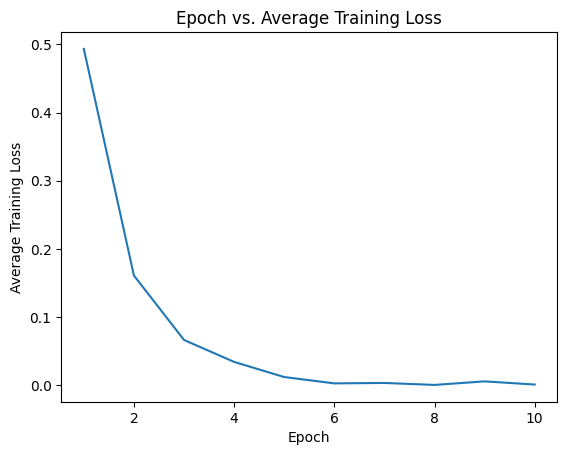

In [25]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(range(1,11), losses)
plt.title('Epoch vs. Average Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Average Training Loss')

In [43]:
flattened_preds1 = [np.argmax(predictions, axis=1).flatten()[i] for i in range(len(predictions))]

In [51]:
from sklearn.metrics import *
acc = np.mean(np.array(flattened_preds)==np.array(true_labels))
prec = precision_score(true_labels, flattened_preds)
rec = recall_score(true_labels, flattened_preds)
f1 = f1_score(true_labels, flattened_preds)

In [35]:
def show_similar_words(reps, words):
    # reps = reps / (np.sqrt((reps ** 2).sum(axis=1, keepdims=True)))
    #for i, (word, token) in enumerate(tokenizer.word_to_token.items()):
    for word in words:
        # word = tokenizer.get_vocab()[token]
        token = tokenizer.get_vocab()[word]
        rep = reps[token, :]
        sims = ((reps - rep) ** 2).sum(axis=1)
        nearest = np.argsort(sims)
        print(word, token)
        for j in nearest[1:6]:
            print(" ", tokenizer.decode([j]), "%.3f" % sims[j])

In [49]:
show_similar_words(model.get_input_embeddings().weight.data.cpu().numpy(), ['#ilovecollege'])

#ilovecollege 30996
  #Intellectual 0.493
  #trumpers 0.501
  #Jinping 0.511
  #BeatNCState 0.514
  #seo 0.523


In [52]:
print(acc, prec, rec, f1)

0.949748743718593 0.9047619047619048 1.0 0.9500000000000001


In [36]:
for i in range(len(test_tweets)):
  if not np.argmax(predictions, axis=1).flatten()[i] == true_labels[i]:
    print(test_tweets[i])
# print(np.argmax(predictions, axis=1).flatten() == true_labels)
# print(true_labels)

#instacraze #addiction
Session the local #1stPhoto #rektek #bmx #lookMamNoHands #flying #fallingWithStyle
What difference years makes #bestfriends #changed #one #bit
Every wondered the take #Thanksgiving?
remember the last time saw mainstream #Software #GangnamStyle #Geek
#Palestinian #Authority #Abbas #trades #stalemate for #confrontation #ICC #move via
#whynot? #why #pop#art #artist #whirleyshot #whirleystudio #sharpie #acrylics
#me and #change were not friends still need #time
would give your for some Pepto Bismol right now #upsettummy
Getting shit together like #2015isthenewturnup #myboos #funtimes #makingmemories


# Scaled Embedding Model

In [45]:
embed = model.get_input_embeddings().weight.data

In [54]:
def scale_embeddings(embed, k):
  new_embed = torch.empty(embed.shape)
  new_embed[:tokenizer.vocab_size] = embed[:tokenizer.vocab_size]
  for i in range(tokenizer.vocab_size, len(tokenizer.get_vocab())):
    scaled = embed[i] * k
    new_embed[i] = scaled
  return new_embed

In [57]:
scaled_accs = []
scaled_precs = []
scaled_recs = []
scaled_f1s = []

In [59]:
for k in np.linspace(1, 10, num=19):
  scaled_embedding = scale_embeddings(embed, k)
  scaled_embedding = scaled_embedding.to(device="cuda")
  scaled_model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-cased', num_labels=2, output_attentions = False, output_hidden_states=False)
  scaled_model.resize_token_embeddings(len(tokenizer))
  scaled_model.to(device)
  scaled_model.set_input_embeddings(torch.nn.Embedding(scaled_embedding.shape[0], scaled_embedding.shape[1], _weight=scaled_embedding))
  scaled_optimizer = AdamW(scaled_model.parameters(),
                lr = 2e-5, # args.learning_rate - default is 5e-5.
                eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
              )
  total_t0 = time.time()
  losses = []
  for epoch in tqdm(range(10)):
    total_train_loss = 0
    scaled_model.train()
    for step, batch in enumerate(train_loader):

      b_input_ids = batch[0].to(device)
      b_input_mask = batch[1].to(device)
      b_labels = batch[2].to(device)
      scaled_model.zero_grad()
      outputs = scaled_model(b_input_ids,
                              attention_mask=b_input_mask,
                              labels=b_labels)
      loss = outputs.loss
      total_train_loss += loss
      loss.backward()
      torch.nn.utils.clip_grad_norm_(scaled_model.parameters(), 1.0)
      scaled_optimizer.step()
      if(step %10 == 0):
        print(loss)

    avg_train_loss = total_train_loss / len(train_loader)
    losses.append(avg_train_loss)
    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode-
    scaled_model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

      # Evaluate data for one epoch
    for batch in val_loader:
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        with torch.no_grad():

            outputs = scaled_model(b_input_ids,
                                    attention_mask=b_input_mask,
                                    labels=b_labels)

        # Accumulate the validation loss.
        loss = outputs.loss
        logits = outputs.logits
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(val_loader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(val_loader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

  print("")
  print("Training complete!")

  print("Total training took {:}".format(format_time(time.time()-total_t0)))

  print('Predicting labels for {:,} test tweets...'.format(len(test_tweets)))

  # Put model in evaluation mode
  scaled_model.eval()

  # Tracking variables
  predictions , true_labels = [], []

  # Predict

  for batch in test_loader:
    # Unpack the inputs from our dataloader
    b_input_ids = batch[0].to(device)
    b_input_mask = batch[1].to(device)
    b_labels = batch[2].to(device)
    # Telling the model not to compute or store gradients, saving memory and
    # speeding up prediction
    with torch.no_grad():
        # Forward pass, calculate logit predictions
        outputs = scaled_model(b_input_ids,
                        attention_mask=b_input_mask)
    logits = outputs[0]

    # Move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()

    # Store predictions and true labels
    predictions.extend(logits)
    true_labels.extend(label_ids)
  print('Final Accuracy: {0}'.format(flat_accuracy(np.asarray(predictions), np.asarray(true_labels))))
  flattened_preds = [np.argmax(predictions, axis=1).flatten()[i] for i in range(len(predictions))]
  acc = np.mean(np.array(flattened_preds)==np.array(true_labels))
  prec = precision_score(true_labels, flattened_preds)
  rec = recall_score(true_labels, flattened_preds)
  f1 = f1_score(true_labels, flattened_preds)

  scaled_accs.append(acc)
  scaled_precs.append(prec)
  scaled_recs.append(rec)
  scaled_f1s.append(f1)

  print('    DONE.')

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.7006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6631, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4550, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3830, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2035, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.43

Running Validation...


 10%|█         | 1/10 [00:11<01:45, 11.68s/it]

  Accuracy: 0.96
  Validation Loss: 0.13
  Validation took: 0:00:01
tensor(0.1030, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0791, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1489, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1562, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1826, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.11

Running Validation...


 20%|██        | 2/10 [00:23<01:34, 11.81s/it]

  Accuracy: 0.96
  Validation Loss: 0.14
  Validation took: 0:00:01
tensor(0.0086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0079, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.03

Running Validation...


 30%|███       | 3/10 [00:35<01:23, 11.96s/it]

  Accuracy: 0.98
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.0046, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1775, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 40%|████      | 4/10 [00:47<01:11, 11.95s/it]

  Accuracy: 0.98
  Validation Loss: 0.09
  Validation took: 0:00:01
tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 50%|█████     | 5/10 [00:59<00:59, 11.88s/it]

  Accuracy: 0.97
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 60%|██████    | 6/10 [01:11<00:47, 11.83s/it]

  Accuracy: 0.99
  Validation Loss: 0.09
  Validation took: 0:00:01
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.80s/it]

  Accuracy: 0.99
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:34<00:23, 11.80s/it]

  Accuracy: 0.98
  Validation Loss: 0.09
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:46<00:11, 11.78s/it]

  Accuracy: 0.99
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:58<00:00, 11.83s/it]

  Accuracy: 0.99
  Validation Loss: 0.08
  Validation took: 0:00:01

Training complete!
Total training took 0:01:58
Predicting labels for 199 test tweets...


Final Accuracy: 0.9798994974874372
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.6973, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6657, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5709, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2690, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2173, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.46

Running Validation...


 10%|█         | 1/10 [00:11<01:47, 11.93s/it]

  Accuracy: 0.95
  Validation Loss: 0.18
  Validation took: 0:00:01
tensor(0.0647, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0444, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0653, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0147, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0285, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.10

Running Validation...


 20%|██        | 2/10 [00:23<01:35, 11.94s/it]

  Accuracy: 0.97
  Validation Loss: 0.12
  Validation took: 0:00:01
tensor(0.0057, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0235, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0308, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0529, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.07

Running Validation...


 30%|███       | 3/10 [00:35<01:23, 11.92s/it]

  Accuracy: 0.98
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.0361, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0051, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0091, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.02

Running Validation...


 40%|████      | 4/10 [00:47<01:11, 11.86s/it]

  Accuracy: 0.97
  Validation Loss: 0.13
  Validation took: 0:00:01
tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 50%|█████     | 5/10 [00:59<00:59, 11.81s/it]

  Accuracy: 0.98
  Validation Loss: 0.12
  Validation took: 0:00:01
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 60%|██████    | 6/10 [01:10<00:47, 11.77s/it]

  Accuracy: 0.97
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.75s/it]

  Accuracy: 0.98
  Validation Loss: 0.13
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:34<00:23, 11.74s/it]

  Accuracy: 0.98
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:46<00:11, 11.74s/it]

  Accuracy: 0.98
  Validation Loss: 0.10
  Validation took: 0:00:01
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:57<00:00, 11.79s/it]

  Accuracy: 0.98
  Validation Loss: 0.11
  Validation took: 0:00:01

Training complete!
Total training took 0:01:58
Predicting labels for 199 test tweets...


Final Accuracy: 0.9849246231155779
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.6940, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6615, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5160, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3309, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3330, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.47

Running Validation...


 10%|█         | 1/10 [00:11<01:45, 11.75s/it]

  Accuracy: 0.95
  Validation Loss: 0.15
  Validation took: 0:00:01
tensor(0.1304, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1124, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0205, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0175, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1292, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.10

Running Validation...


 20%|██        | 2/10 [00:23<01:33, 11.73s/it]

  Accuracy: 0.96
  Validation Loss: 0.13
  Validation took: 0:00:01
tensor(0.0147, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1580, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1947, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0975, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.03

Running Validation...


 30%|███       | 3/10 [00:35<01:22, 11.75s/it]

  Accuracy: 0.98
  Validation Loss: 0.07
  Validation took: 0:00:01
tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 40%|████      | 4/10 [00:46<01:10, 11.75s/it]

  Accuracy: 0.96
  Validation Loss: 0.16
  Validation took: 0:00:01
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1625, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 50%|█████     | 5/10 [00:58<00:59, 11.80s/it]

  Accuracy: 0.98
  Validation Loss: 0.09
  Validation took: 0:00:01
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 60%|██████    | 6/10 [01:10<00:47, 11.83s/it]

  Accuracy: 0.98
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.83s/it]

  Accuracy: 0.94
  Validation Loss: 0.40
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:34<00:23, 11.81s/it]

  Accuracy: 0.98
  Validation Loss: 0.12
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:46<00:11, 11.80s/it]

  Accuracy: 0.98
  Validation Loss: 0.13
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:57<00:00, 11.79s/it]

  Accuracy: 0.98
  Validation Loss: 0.13
  Validation took: 0:00:01

Training complete!
Total training took 0:01:58
Predicting labels for 199 test tweets...


Final Accuracy: 0.9698492462311558
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.6978, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6696, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4943, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4386, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2012, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.46

Running Validation...


 10%|█         | 1/10 [00:11<01:45, 11.71s/it]

  Accuracy: 0.96
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0863, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0304, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0269, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0139, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0066, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.07

Running Validation...


 20%|██        | 2/10 [00:23<01:33, 11.74s/it]

  Accuracy: 0.97
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.1181, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0311, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0330, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.04

Running Validation...


 30%|███       | 3/10 [00:35<01:22, 11.76s/it]

  Accuracy: 0.98
  Validation Loss: 0.07
  Validation took: 0:00:01
tensor(0.0071, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0083, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0058, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 40%|████      | 4/10 [00:47<01:10, 11.77s/it]

  Accuracy: 0.98
  Validation Loss: 0.09
  Validation took: 0:00:01
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 50%|█████     | 5/10 [00:59<00:59, 11.85s/it]

  Accuracy: 0.98
  Validation Loss: 0.06
  Validation took: 0:00:01
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 60%|██████    | 6/10 [01:10<00:47, 11.81s/it]

  Accuracy: 0.98
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.79s/it]

  Accuracy: 0.99
  Validation Loss: 0.09
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0377, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 80%|████████  | 8/10 [01:34<00:23, 11.77s/it]

  Accuracy: 0.98
  Validation Loss: 0.15
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:45<00:11, 11.75s/it]

  Accuracy: 0.98
  Validation Loss: 0.12
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:57<00:00, 11.76s/it]

  Accuracy: 0.98
  Validation Loss: 0.12
  Validation took: 0:00:01

Training complete!
Total training took 0:01:58
Predicting labels for 199 test tweets...


Final Accuracy: 0.9748743718592965
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.7018, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6429, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4862, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3026, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2286, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.42

Running Validation...


 10%|█         | 1/10 [00:11<01:45, 11.73s/it]

  Accuracy: 0.92
  Validation Loss: 0.23
  Validation took: 0:00:01
tensor(0.0756, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1743, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1553, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1125, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0128, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.10

Running Validation...


 20%|██        | 2/10 [00:23<01:33, 11.74s/it]

  Accuracy: 0.92
  Validation Loss: 0.30
  Validation took: 0:00:01
tensor(0.0179, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3574, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0096, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0039, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.04

Running Validation...


 30%|███       | 3/10 [00:35<01:22, 11.85s/it]

  Accuracy: 0.97
  Validation Loss: 0.12
  Validation took: 0:00:01
tensor(0.0876, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0064, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.02

Running Validation...


 40%|████      | 4/10 [00:47<01:11, 11.99s/it]

  Accuracy: 0.97
  Validation Loss: 0.10
  Validation took: 0:00:01
tensor(0.0195, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 50%|█████     | 5/10 [00:59<00:59, 11.95s/it]

  Accuracy: 0.99
  Validation Loss: 0.05
  Validation took: 0:00:01
tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 60%|██████    | 6/10 [01:11<00:47, 11.92s/it]

  Accuracy: 0.99
  Validation Loss: 0.05
  Validation took: 0:00:01
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:23<00:35, 11.89s/it]

  Accuracy: 0.98
  Validation Loss: 0.06
  Validation took: 0:00:01
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:35<00:23, 11.86s/it]

  Accuracy: 0.99
  Validation Loss: 0.07
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:46<00:11, 11.83s/it]

  Accuracy: 0.98
  Validation Loss: 0.07
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:58<00:00, 11.86s/it]

  Accuracy: 0.98
  Validation Loss: 0.07
  Validation took: 0:00:01

Training complete!
Total training took 0:01:59
Predicting labels for 199 test tweets...


Final Accuracy: 0.9798994974874372
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.7012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6101, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4826, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3045, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0862, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.41

Running Validation...


 10%|█         | 1/10 [00:12<01:49, 12.19s/it]

  Accuracy: 0.96
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.1328, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0744, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0113, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0094, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1439, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.07

Running Validation...


 20%|██        | 2/10 [00:24<01:36, 12.02s/it]

  Accuracy: 0.97
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.0072, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0074, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0060, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1325, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.03

Running Validation...


 30%|███       | 3/10 [00:36<01:23, 11.98s/it]

  Accuracy: 0.99
  Validation Loss: 0.05
  Validation took: 0:00:01
tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0049, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.03

Running Validation...


 40%|████      | 4/10 [00:47<01:11, 11.91s/it]

  Accuracy: 0.97
  Validation Loss: 0.10
  Validation took: 0:00:01
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 50%|█████     | 5/10 [00:59<00:59, 11.85s/it]

  Accuracy: 0.97
  Validation Loss: 0.12
  Validation took: 0:00:01
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 60%|██████    | 6/10 [01:11<00:47, 11.83s/it]

  Accuracy: 0.97
  Validation Loss: 0.15
  Validation took: 0:00:01
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:23<00:35, 11.83s/it]

  Accuracy: 0.97
  Validation Loss: 0.21
  Validation took: 0:00:01
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 80%|████████  | 8/10 [01:35<00:23, 11.84s/it]

  Accuracy: 0.94
  Validation Loss: 0.28
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:46<00:11, 11.83s/it]

  Accuracy: 0.99
  Validation Loss: 0.06
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:58<00:00, 11.87s/it]

  Accuracy: 0.99
  Validation Loss: 0.05
  Validation took: 0:00:01

Training complete!
Total training took 0:01:59
Predicting labels for 199 test tweets...


Final Accuracy: 0.9798994974874372
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.7064, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6532, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4888, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3457, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1499, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.45

Running Validation...


 10%|█         | 1/10 [00:11<01:46, 11.83s/it]

  Accuracy: 0.96
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0579, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1359, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0222, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3351, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0160, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.09

Running Validation...


 20%|██        | 2/10 [00:23<01:35, 11.90s/it]

  Accuracy: 0.97
  Validation Loss: 0.07
  Validation took: 0:00:01
tensor(0.0052, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0136, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0061, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1014, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.04

Running Validation...


 30%|███       | 3/10 [00:35<01:23, 11.94s/it]

  Accuracy: 0.98
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.0030, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1265, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0761, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.02

Running Validation...


 40%|████      | 4/10 [00:47<01:11, 11.95s/it]

  Accuracy: 0.99
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0348, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 50%|█████     | 5/10 [00:59<00:59, 11.89s/it]

  Accuracy: 0.96
  Validation Loss: 0.17
  Validation took: 0:00:01
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 60%|██████    | 6/10 [01:11<00:47, 11.83s/it]

  Accuracy: 0.99
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.78s/it]

  Accuracy: 0.97
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:34<00:23, 11.76s/it]

  Accuracy: 0.98
  Validation Loss: 0.10
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:46<00:11, 11.74s/it]

  Accuracy: 0.98
  Validation Loss: 0.09
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:58<00:00, 11.81s/it]

  Accuracy: 0.98
  Validation Loss: 0.10
  Validation took: 0:00:01

Training complete!
Total training took 0:01:58
Predicting labels for 199 test tweets...


Final Accuracy: 0.9798994974874372
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.6882, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6057, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4688, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3510, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1967, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.42

Running Validation...


 10%|█         | 1/10 [00:11<01:46, 11.81s/it]

  Accuracy: 0.97
  Validation Loss: 0.09
  Validation took: 0:00:01
tensor(0.2488, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2562, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2600, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0707, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0066, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.09

Running Validation...


 20%|██        | 2/10 [00:23<01:34, 11.80s/it]

  Accuracy: 0.96
  Validation Loss: 0.15
  Validation took: 0:00:01
tensor(0.0054, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1960, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0141, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0240, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.03

Running Validation...


 30%|███       | 3/10 [00:35<01:22, 11.80s/it]

  Accuracy: 0.96
  Validation Loss: 0.18
  Validation took: 0:00:01
tensor(0.0052, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 40%|████      | 4/10 [00:47<01:10, 11.78s/it]

  Accuracy: 0.98
  Validation Loss: 0.06
  Validation took: 0:00:01
tensor(0.0556, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 50%|█████     | 5/10 [00:58<00:58, 11.77s/it]

  Accuracy: 0.97
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 60%|██████    | 6/10 [01:10<00:47, 11.76s/it]

  Accuracy: 0.97
  Validation Loss: 0.10
  Validation took: 0:00:01
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.74s/it]

  Accuracy: 0.97
  Validation Loss: 0.12
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:34<00:23, 11.74s/it]

  Accuracy: 0.93
  Validation Loss: 0.46
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:45<00:11, 11.74s/it]

  Accuracy: 0.93
  Validation Loss: 0.48
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:57<00:00, 11.75s/it]

  Accuracy: 0.98
  Validation Loss: 0.13
  Validation took: 0:00:01

Training complete!
Total training took 0:01:58
Predicting labels for 199 test tweets...


Final Accuracy: 0.964824120603015
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.6918, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6704, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5252, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3401, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3924, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.50

Running Validation...


 10%|█         | 1/10 [00:11<01:46, 11.84s/it]

  Accuracy: 0.93
  Validation Loss: 0.22
  Validation took: 0:00:01
tensor(0.2439, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1362, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1148, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1173, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0157, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.14

Running Validation...


 20%|██        | 2/10 [00:23<01:34, 11.79s/it]

  Accuracy: 0.96
  Validation Loss: 0.10
  Validation took: 0:00:01
tensor(0.0098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0149, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1097, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0042, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.05

Running Validation...


 30%|███       | 3/10 [00:35<01:22, 11.79s/it]

  Accuracy: 0.97
  Validation Loss: 0.09
  Validation took: 0:00:01
tensor(0.1572, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1847, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1897, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.02

Running Validation...


 40%|████      | 4/10 [00:47<01:10, 11.79s/it]

  Accuracy: 0.97
  Validation Loss: 0.13
  Validation took: 0:00:01
tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2177, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 50%|█████     | 5/10 [00:58<00:58, 11.77s/it]

  Accuracy: 0.97
  Validation Loss: 0.19
  Validation took: 0:00:01
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 60%|██████    | 6/10 [01:10<00:47, 11.75s/it]

  Accuracy: 0.97
  Validation Loss: 0.20
  Validation took: 0:00:01
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.75s/it]

  Accuracy: 0.98
  Validation Loss: 0.16
  Validation took: 0:00:01
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:34<00:23, 11.74s/it]

  Accuracy: 0.98
  Validation Loss: 0.12
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:45<00:11, 11.74s/it]

  Accuracy: 0.93
  Validation Loss: 0.45
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:57<00:00, 11.76s/it]

  Accuracy: 0.97
  Validation Loss: 0.11
  Validation took: 0:00:01

Training complete!
Total training took 0:01:58
Predicting labels for 199 test tweets...


Final Accuracy: 0.9748743718592965
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.7209, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6260, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4675, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3230, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2835, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.45

Running Validation...


 10%|█         | 1/10 [00:11<01:46, 11.80s/it]

  Accuracy: 0.96
  Validation Loss: 0.12
  Validation took: 0:00:01
tensor(0.1924, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0489, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0165, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0241, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1364, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.09

Running Validation...


 20%|██        | 2/10 [00:23<01:34, 11.77s/it]

  Accuracy: 0.96
  Validation Loss: 0.18
  Validation took: 0:00:01
tensor(0.3630, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0055, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0098, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1138, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0032, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.04

Running Validation...


 30%|███       | 3/10 [00:35<01:22, 11.78s/it]

  Accuracy: 0.97
  Validation Loss: 0.12
  Validation took: 0:00:01
tensor(0.0032, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.02

Running Validation...


 40%|████      | 4/10 [00:47<01:10, 11.77s/it]

  Accuracy: 0.96
  Validation Loss: 0.17
  Validation took: 0:00:01
tensor(0.1812, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0261, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 50%|█████     | 5/10 [00:58<00:58, 11.76s/it]

  Accuracy: 0.98
  Validation Loss: 0.09
  Validation took: 0:00:01
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0682, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 60%|██████    | 6/10 [01:10<00:47, 11.75s/it]

  Accuracy: 0.97
  Validation Loss: 0.12
  Validation took: 0:00:01
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.74s/it]

  Accuracy: 0.97
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:33<00:23, 11.73s/it]

  Accuracy: 0.98
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:45<00:11, 11.72s/it]

  Accuracy: 0.97
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:57<00:00, 11.74s/it]

  Accuracy: 0.97
  Validation Loss: 0.08
  Validation took: 0:00:01

Training complete!
Total training took 0:01:57
Predicting labels for 199 test tweets...


Final Accuracy: 0.9798994974874372
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.6998, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6366, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5560, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3115, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1791, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.43

Running Validation...


 10%|█         | 1/10 [00:11<01:46, 11.78s/it]

  Accuracy: 0.96
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0624, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1343, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1589, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1119, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.08

Running Validation...


 20%|██        | 2/10 [00:23<01:34, 11.76s/it]

  Accuracy: 0.97
  Validation Loss: 0.06
  Validation took: 0:00:01
tensor(0.0101, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0140, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0048, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0036, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.03

Running Validation...


 30%|███       | 3/10 [00:35<01:22, 11.77s/it]

  Accuracy: 0.96
  Validation Loss: 0.18
  Validation took: 0:00:01
tensor(0.0027, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.02

Running Validation...


 40%|████      | 4/10 [00:47<01:10, 11.77s/it]

  Accuracy: 0.97
  Validation Loss: 0.10
  Validation took: 0:00:01
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 50%|█████     | 5/10 [00:58<00:58, 11.76s/it]

  Accuracy: 0.94
  Validation Loss: 0.26
  Validation took: 0:00:01
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 60%|██████    | 6/10 [01:10<00:47, 11.75s/it]

  Accuracy: 0.97
  Validation Loss: 0.13
  Validation took: 0:00:01
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.74s/it]

  Accuracy: 0.97
  Validation Loss: 0.16
  Validation took: 0:00:01
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:33<00:23, 11.72s/it]

  Accuracy: 0.97
  Validation Loss: 0.13
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:45<00:11, 11.71s/it]

  Accuracy: 0.98
  Validation Loss: 0.12
  Validation took: 0:00:01
tensor(0.0399, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:57<00:00, 11.74s/it]

  Accuracy: 0.98
  Validation Loss: 0.11
  Validation took: 0:00:01

Training complete!
Total training took 0:01:57
Predicting labels for 199 test tweets...


Final Accuracy: 0.9748743718592965
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.6649, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6527, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5484, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3665, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3624, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.46

Running Validation...


 10%|█         | 1/10 [00:11<01:45, 11.76s/it]

  Accuracy: 0.95
  Validation Loss: 0.15
  Validation took: 0:00:01
tensor(0.0467, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1503, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0289, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3403, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1516, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.10

Running Validation...


 20%|██        | 2/10 [00:23<01:34, 11.75s/it]

  Accuracy: 0.96
  Validation Loss: 0.13
  Validation took: 0:00:01
tensor(0.1605, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0184, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1574, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0035, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.04

Running Validation...


 30%|███       | 3/10 [00:35<01:22, 11.77s/it]

  Accuracy: 0.96
  Validation Loss: 0.16
  Validation took: 0:00:01
tensor(0.0162, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0039, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.02

Running Validation...


 40%|████      | 4/10 [00:47<01:10, 11.77s/it]

  Accuracy: 0.98
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 50%|█████     | 5/10 [00:58<00:58, 11.76s/it]

  Accuracy: 0.97
  Validation Loss: 0.14
  Validation took: 0:00:01
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 60%|██████    | 6/10 [01:10<00:47, 11.76s/it]

  Accuracy: 0.97
  Validation Loss: 0.14
  Validation took: 0:00:01
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.75s/it]

  Accuracy: 0.96
  Validation Loss: 0.17
  Validation took: 0:00:01
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:34<00:23, 11.74s/it]

  Accuracy: 0.97
  Validation Loss: 0.17
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:45<00:11, 11.73s/it]

  Accuracy: 0.97
  Validation Loss: 0.18
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:57<00:00, 11.75s/it]

  Accuracy: 0.93
  Validation Loss: 0.25
  Validation took: 0:00:01

Training complete!
Total training took 0:01:57
Predicting labels for 199 test tweets...


Final Accuracy: 0.9748743718592965
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.7360, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6494, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4602, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2541, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.48

Running Validation...


 10%|█         | 1/10 [00:11<01:45, 11.71s/it]

  Accuracy: 0.96
  Validation Loss: 0.15
  Validation took: 0:00:01
tensor(0.1075, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1545, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1847, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0384, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1780, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.12

Running Validation...


 20%|██        | 2/10 [00:23<01:33, 11.73s/it]

  Accuracy: 0.99
  Validation Loss: 0.06
  Validation took: 0:00:01
tensor(0.1352, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1537, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0092, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0227, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.05

Running Validation...


 30%|███       | 3/10 [00:35<01:22, 11.74s/it]

  Accuracy: 0.93
  Validation Loss: 0.36
  Validation took: 0:00:01
tensor(0.0039, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0049, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1323, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0126, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.05

Running Validation...


 40%|████      | 4/10 [00:46<01:10, 11.76s/it]

  Accuracy: 0.97
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0026, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 50%|█████     | 5/10 [00:58<00:58, 11.76s/it]

  Accuracy: 0.98
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 60%|██████    | 6/10 [01:10<00:47, 11.75s/it]

  Accuracy: 0.98
  Validation Loss: 0.09
  Validation took: 0:00:01
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.75s/it]

  Accuracy: 0.98
  Validation Loss: 0.16
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:33<00:23, 11.75s/it]

  Accuracy: 0.97
  Validation Loss: 0.14
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:45<00:11, 11.75s/it]

  Accuracy: 0.98
  Validation Loss: 0.18
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:57<00:00, 11.75s/it]

  Accuracy: 0.98
  Validation Loss: 0.18
  Validation took: 0:00:01

Training complete!
Total training took 0:01:57
Predicting labels for 199 test tweets...


Final Accuracy: 0.9849246231155779
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.7107, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6411, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5115, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2063, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1044, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.42

Running Validation...


 10%|█         | 1/10 [00:11<01:45, 11.74s/it]

  Accuracy: 0.96
  Validation Loss: 0.12
  Validation took: 0:00:01
tensor(0.0455, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0343, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0358, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1333, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0130, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.08

Running Validation...


 20%|██        | 2/10 [00:23<01:33, 11.73s/it]

  Accuracy: 0.96
  Validation Loss: 0.15
  Validation took: 0:00:01
tensor(0.0146, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0046, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0039, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.03

Running Validation...


 30%|███       | 3/10 [00:35<01:22, 11.74s/it]

  Accuracy: 0.96
  Validation Loss: 0.19
  Validation took: 0:00:01
tensor(0.0024, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0015, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 40%|████      | 4/10 [00:46<01:10, 11.74s/it]

  Accuracy: 0.97
  Validation Loss: 0.12
  Validation took: 0:00:01
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 50%|█████     | 5/10 [00:58<00:58, 11.75s/it]

  Accuracy: 0.97
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 60%|██████    | 6/10 [01:10<00:47, 11.75s/it]

  Accuracy: 0.98
  Validation Loss: 0.13
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0715, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.74s/it]

  Accuracy: 0.97
  Validation Loss: 0.16
  Validation took: 0:00:01
tensor(0.0108, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:33<00:23, 11.74s/it]

  Accuracy: 0.98
  Validation Loss: 0.16
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:45<00:11, 11.74s/it]

  Accuracy: 0.97
  Validation Loss: 0.16
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:57<00:00, 11.74s/it]

  Accuracy: 0.97
  Validation Loss: 0.21
  Validation took: 0:00:01

Training complete!
Total training took 0:01:57
Predicting labels for 199 test tweets...


Final Accuracy: 0.9597989949748744
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.6951, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6754, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5489, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3310, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.3291, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.44

Running Validation...


 10%|█         | 1/10 [00:11<01:45, 11.72s/it]

  Accuracy: 0.95
  Validation Loss: 0.15
  Validation took: 0:00:01
tensor(0.0883, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0239, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0203, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0109, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0103, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.10

Running Validation...


 20%|██        | 2/10 [00:23<01:33, 11.72s/it]

  Accuracy: 0.97
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0094, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0059, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0068, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0062, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0137, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.03

Running Validation...


 30%|███       | 3/10 [00:35<01:22, 11.72s/it]

  Accuracy: 0.96
  Validation Loss: 0.09
  Validation took: 0:00:01
tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0031, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 40%|████      | 4/10 [00:46<01:10, 11.74s/it]

  Accuracy: 0.98
  Validation Loss: 0.09
  Validation took: 0:00:01
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 50%|█████     | 5/10 [00:58<00:58, 11.74s/it]

  Accuracy: 0.97
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 60%|██████    | 6/10 [01:10<00:46, 11.75s/it]

  Accuracy: 0.97
  Validation Loss: 0.16
  Validation took: 0:00:01
tensor(0.0067, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.74s/it]

  Accuracy: 0.97
  Validation Loss: 0.17
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 80%|████████  | 8/10 [01:33<00:23, 11.73s/it]

  Accuracy: 0.93
  Validation Loss: 0.56
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:45<00:11, 11.73s/it]

  Accuracy: 0.98
  Validation Loss: 0.14
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:57<00:00, 11.73s/it]

  Accuracy: 0.96
  Validation Loss: 0.28
  Validation took: 0:00:01

Training complete!
Total training took 0:01:57
Predicting labels for 199 test tweets...


Final Accuracy: 0.9597989949748744
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.7201, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6770, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5608, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.4396, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2715, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.45

Running Validation...


 10%|█         | 1/10 [00:11<01:46, 11.78s/it]

  Accuracy: 0.94
  Validation Loss: 0.18
  Validation took: 0:00:01
tensor(0.1755, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2218, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0213, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0115, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0074, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.10

Running Validation...


 20%|██        | 2/10 [00:23<01:34, 11.75s/it]

  Accuracy: 0.98
  Validation Loss: 0.07
  Validation took: 0:00:01
tensor(0.0256, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0090, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0106, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0040, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0033, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.03

Running Validation...


 30%|███       | 3/10 [00:35<01:22, 11.75s/it]

  Accuracy: 0.98
  Validation Loss: 0.10
  Validation took: 0:00:01
tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0199, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0018, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 40%|████      | 4/10 [00:47<01:10, 11.76s/it]

  Accuracy: 0.97
  Validation Loss: 0.17
  Validation took: 0:00:01
tensor(0.0795, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2143, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0021, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 50%|█████     | 5/10 [00:58<00:58, 11.76s/it]

  Accuracy: 0.98
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 60%|██████    | 6/10 [01:10<00:46, 11.75s/it]

  Accuracy: 0.98
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.73s/it]

  Accuracy: 0.97
  Validation Loss: 0.18
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:33<00:23, 11.71s/it]

  Accuracy: 0.98
  Validation Loss: 0.14
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:45<00:11, 11.71s/it]

  Accuracy: 0.94
  Validation Loss: 0.36
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:57<00:00, 11.73s/it]

  Accuracy: 0.98
  Validation Loss: 0.14
  Validation took: 0:00:01

Training complete!
Total training took 0:01:57
Predicting labels for 199 test tweets...


Final Accuracy: 0.9949748743718593
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.7083, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6989, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5791, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2980, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2101, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.46

Running Validation...


 10%|█         | 1/10 [00:11<01:45, 11.70s/it]

  Accuracy: 0.96
  Validation Loss: 0.13
  Validation took: 0:00:01
tensor(0.2523, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1500, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0409, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0205, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1989, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.10

Running Validation...


 20%|██        | 2/10 [00:23<01:33, 11.72s/it]

  Accuracy: 0.97
  Validation Loss: 0.07
  Validation took: 0:00:01
tensor(0.0088, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0410, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0052, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0299, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.03

Running Validation...


 30%|███       | 3/10 [00:35<01:22, 11.74s/it]

  Accuracy: 0.98
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0025, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0030, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0706, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0017, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0016, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 40%|████      | 4/10 [00:46<01:10, 11.74s/it]

  Accuracy: 0.94
  Validation Loss: 0.17
  Validation took: 0:00:01
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 50%|█████     | 5/10 [00:58<00:58, 11.74s/it]

  Accuracy: 0.98
  Validation Loss: 0.05
  Validation took: 0:00:01
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 60%|██████    | 6/10 [01:10<00:47, 11.76s/it]

  Accuracy: 0.98
  Validation Loss: 0.06
  Validation took: 0:00:01
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.77s/it]

  Accuracy: 0.98
  Validation Loss: 0.07
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:34<00:23, 11.76s/it]

  Accuracy: 0.99
  Validation Loss: 0.06
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:45<00:11, 11.75s/it]

  Accuracy: 0.98
  Validation Loss: 0.04
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0013, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:57<00:00, 11.74s/it]

  Accuracy: 0.99
  Validation Loss: 0.06
  Validation took: 0:00:01

Training complete!
Total training took 0:01:57
Predicting labels for 199 test tweets...


Final Accuracy: 0.9849246231155779
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.6953, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6475, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5086, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2639, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1800, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.44

Running Validation...


 10%|█         | 1/10 [00:11<01:46, 11.80s/it]

  Accuracy: 0.96
  Validation Loss: 0.12
  Validation took: 0:00:01
tensor(0.1066, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0604, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1485, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0325, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0178, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.09

Running Validation...


 20%|██        | 2/10 [00:23<01:34, 11.76s/it]

  Accuracy: 0.96
  Validation Loss: 0.07
  Validation took: 0:00:01
tensor(0.0105, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0076, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0040, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0900, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.04

Running Validation...


 30%|███       | 3/10 [00:35<01:22, 11.77s/it]

  Accuracy: 0.98
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.0041, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1151, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0043, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.02

Running Validation...


 40%|████      | 4/10 [00:47<01:10, 11.76s/it]

  Accuracy: 0.97
  Validation Loss: 0.10
  Validation took: 0:00:01
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0011, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0010, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 50%|█████     | 5/10 [00:58<00:58, 11.75s/it]

  Accuracy: 0.97
  Validation Loss: 0.13
  Validation took: 0:00:01
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0559, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 60%|██████    | 6/10 [01:10<00:46, 11.74s/it]

  Accuracy: 0.99
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0022, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.74s/it]

  Accuracy: 0.98
  Validation Loss: 0.09
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:33<00:23, 11.73s/it]

  Accuracy: 0.97
  Validation Loss: 0.11
  Validation took: 0:00:01
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0397, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:45<00:11, 11.73s/it]

  Accuracy: 0.98
  Validation Loss: 0.10
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0006, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:57<00:00, 11.74s/it]

  Accuracy: 0.97
  Validation Loss: 0.15
  Validation took: 0:00:01

Training complete!
Total training took 0:01:57
Predicting labels for 199 test tweets...


Final Accuracy: 0.9748743718592965
    DONE.


Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-cased and are newly initialized: ['pre_classifier.weight', 'classifier.weight', 'pre_classifier.bias', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
  0%|          | 0/10 [00:00<?, ?it/s]

tensor(0.6998, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.6546, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.5249, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2743, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.2490, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.42

Running Validation...


 10%|█         | 1/10 [00:11<01:45, 11.70s/it]

  Accuracy: 0.95
  Validation Loss: 0.13
  Validation took: 0:00:01
tensor(0.0438, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0283, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1546, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.1555, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0117, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.09

Running Validation...


 20%|██        | 2/10 [00:23<01:33, 11.72s/it]

  Accuracy: 0.96
  Validation Loss: 0.10
  Validation took: 0:00:01
tensor(0.0089, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0095, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0170, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.03

Running Validation...


 30%|███       | 3/10 [00:35<01:22, 11.74s/it]

  Accuracy: 0.97
  Validation Loss: 0.08
  Validation took: 0:00:01
tensor(0.0026, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0019, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0020, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0014, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 40%|████      | 4/10 [00:46<01:10, 11.75s/it]

  Accuracy: 0.98
  Validation Loss: 0.10
  Validation took: 0:00:01
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0008, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0009, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0023, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.01

Running Validation...


 50%|█████     | 5/10 [00:58<00:58, 11.75s/it]

  Accuracy: 0.97
  Validation Loss: 0.10
  Validation took: 0:00:01
tensor(0.0007, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0012, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 60%|██████    | 6/10 [01:10<00:46, 11.75s/it]

  Accuracy: 0.97
  Validation Loss: 0.14
  Validation took: 0:00:01
tensor(0.0005, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 70%|███████   | 7/10 [01:22<00:35, 11.74s/it]

  Accuracy: 0.96
  Validation Loss: 0.19
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0004, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 80%|████████  | 8/10 [01:33<00:23, 11.73s/it]

  Accuracy: 0.97
  Validation Loss: 0.14
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


 90%|█████████ | 9/10 [01:45<00:11, 11.72s/it]

  Accuracy: 0.97
  Validation Loss: 0.14
  Validation took: 0:00:01
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0002, device='cuda:0', grad_fn=<NllLossBackward0>)
tensor(0.0001, device='cuda:0', grad_fn=<NllLossBackward0>)

  Average training loss: 0.00

Running Validation...


100%|██████████| 10/10 [01:57<00:00, 11.73s/it]

  Accuracy: 0.96
  Validation Loss: 0.23
  Validation took: 0:00:01

Training complete!
Total training took 0:01:57
Predicting labels for 199 test tweets...


Final Accuracy: 0.9597989949748744
    DONE.


In [60]:
# print(np.mean(accs1), np.mean(prec1), np.mean(recs1), np.mean(f1s1))
print(max(scaled_accs), max(scaled_precs), max(scaled_recs), max(scaled_f1s))
print(f'max k accs: {np.argmax(scaled_accs)/2+1}')
print(f'max k precs: {np.argmax(scaled_precs)/2+1}')
print(f'max k recs: {np.argmax(scaled_recs)/2+1}')
print(f'max k f1s: {np.argmax(scaled_f1s)/2+1}')

0.9949748743718593 1.0 1.0 0.9947089947089947
max k accs: 8.5
max k precs: 8.5
max k recs: 2.5
max k f1s: 8.5


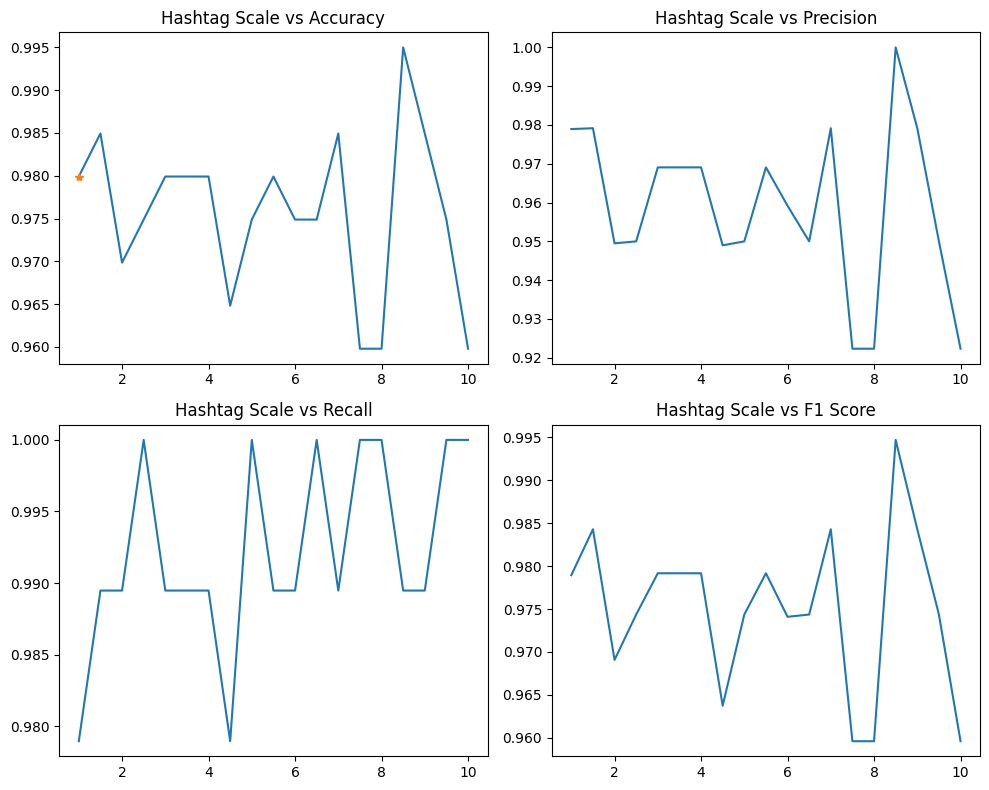

In [71]:
import matplotlib.pyplot as plt
fig, axs = plt.subplots(2, 2, figsize=(10, 8))

# Plot 1: Hashtag Scale vs Accuracy
axs[0, 0].set_title("Hashtag Scale vs Accuracy")
axs[0, 0].plot(np.linspace(1, 10, 19), scaled_accs)
axs[0, 0].plot(1, scaled_accs[0], '*')

# Plot 2: Hashtag Scale vs Precision
axs[0, 1].set_title("Hashtag Scale vs Precision")
axs[0, 1].plot(np.linspace(1, 10, 19), scaled_precs)

# Plot 3: Hashtag Scale vs Recall
axs[1, 0].set_title("Hashtag Scale vs Recall")
axs[1, 0].plot(np.linspace(1, 10, 19), scaled_recs)

# Plot 4: Hashtag Scale vs F1 Score
axs[1, 1].set_title("Hashtag Scale vs F1 Score")
axs[1, 1].plot(np.linspace(1, 10, 19), scaled_f1s)

# Adjust layout to prevent overlapping titles and labels
plt.tight_layout()

In [46]:
from sklearn.manifold import TSNE

labels = []
tokens = []
preds = []

for i in range(len(flattened_preds1)):
  tweet = test_tweets[i]
  words = tweet.split()
  pred = flattened_preds1[i]
  for word in words:
    if word in tokenizer.get_vocab() and word not in labels and word[0]=='#':
      labels.append(word)
      j = tokenizer.get_vocab()[word]
      tokens.append(embed[j, :].cpu().numpy())
      preds.append(pred)

# for i in vectorizer.tokenizer.token_to_word:
#   tokens.append(reps_word2vec[i, :])
#   labels.append(vectorizer.tokenizer.token_to_word[i])

tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
new_values = tsne_model.fit_transform(np.array(tokens))

/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3648 (\N{THAI CHARACTER SARA E}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3621 (\N{THAI CHARACTER LO LING}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3639 (\N{THAI CHARACTER SARA UEE}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3629 (\N{THAI CHARACTER O ANG}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 3585 (\N{THAI CHARACTER KO KAI}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)
/usr/local/lib/python3.10/dist-pa

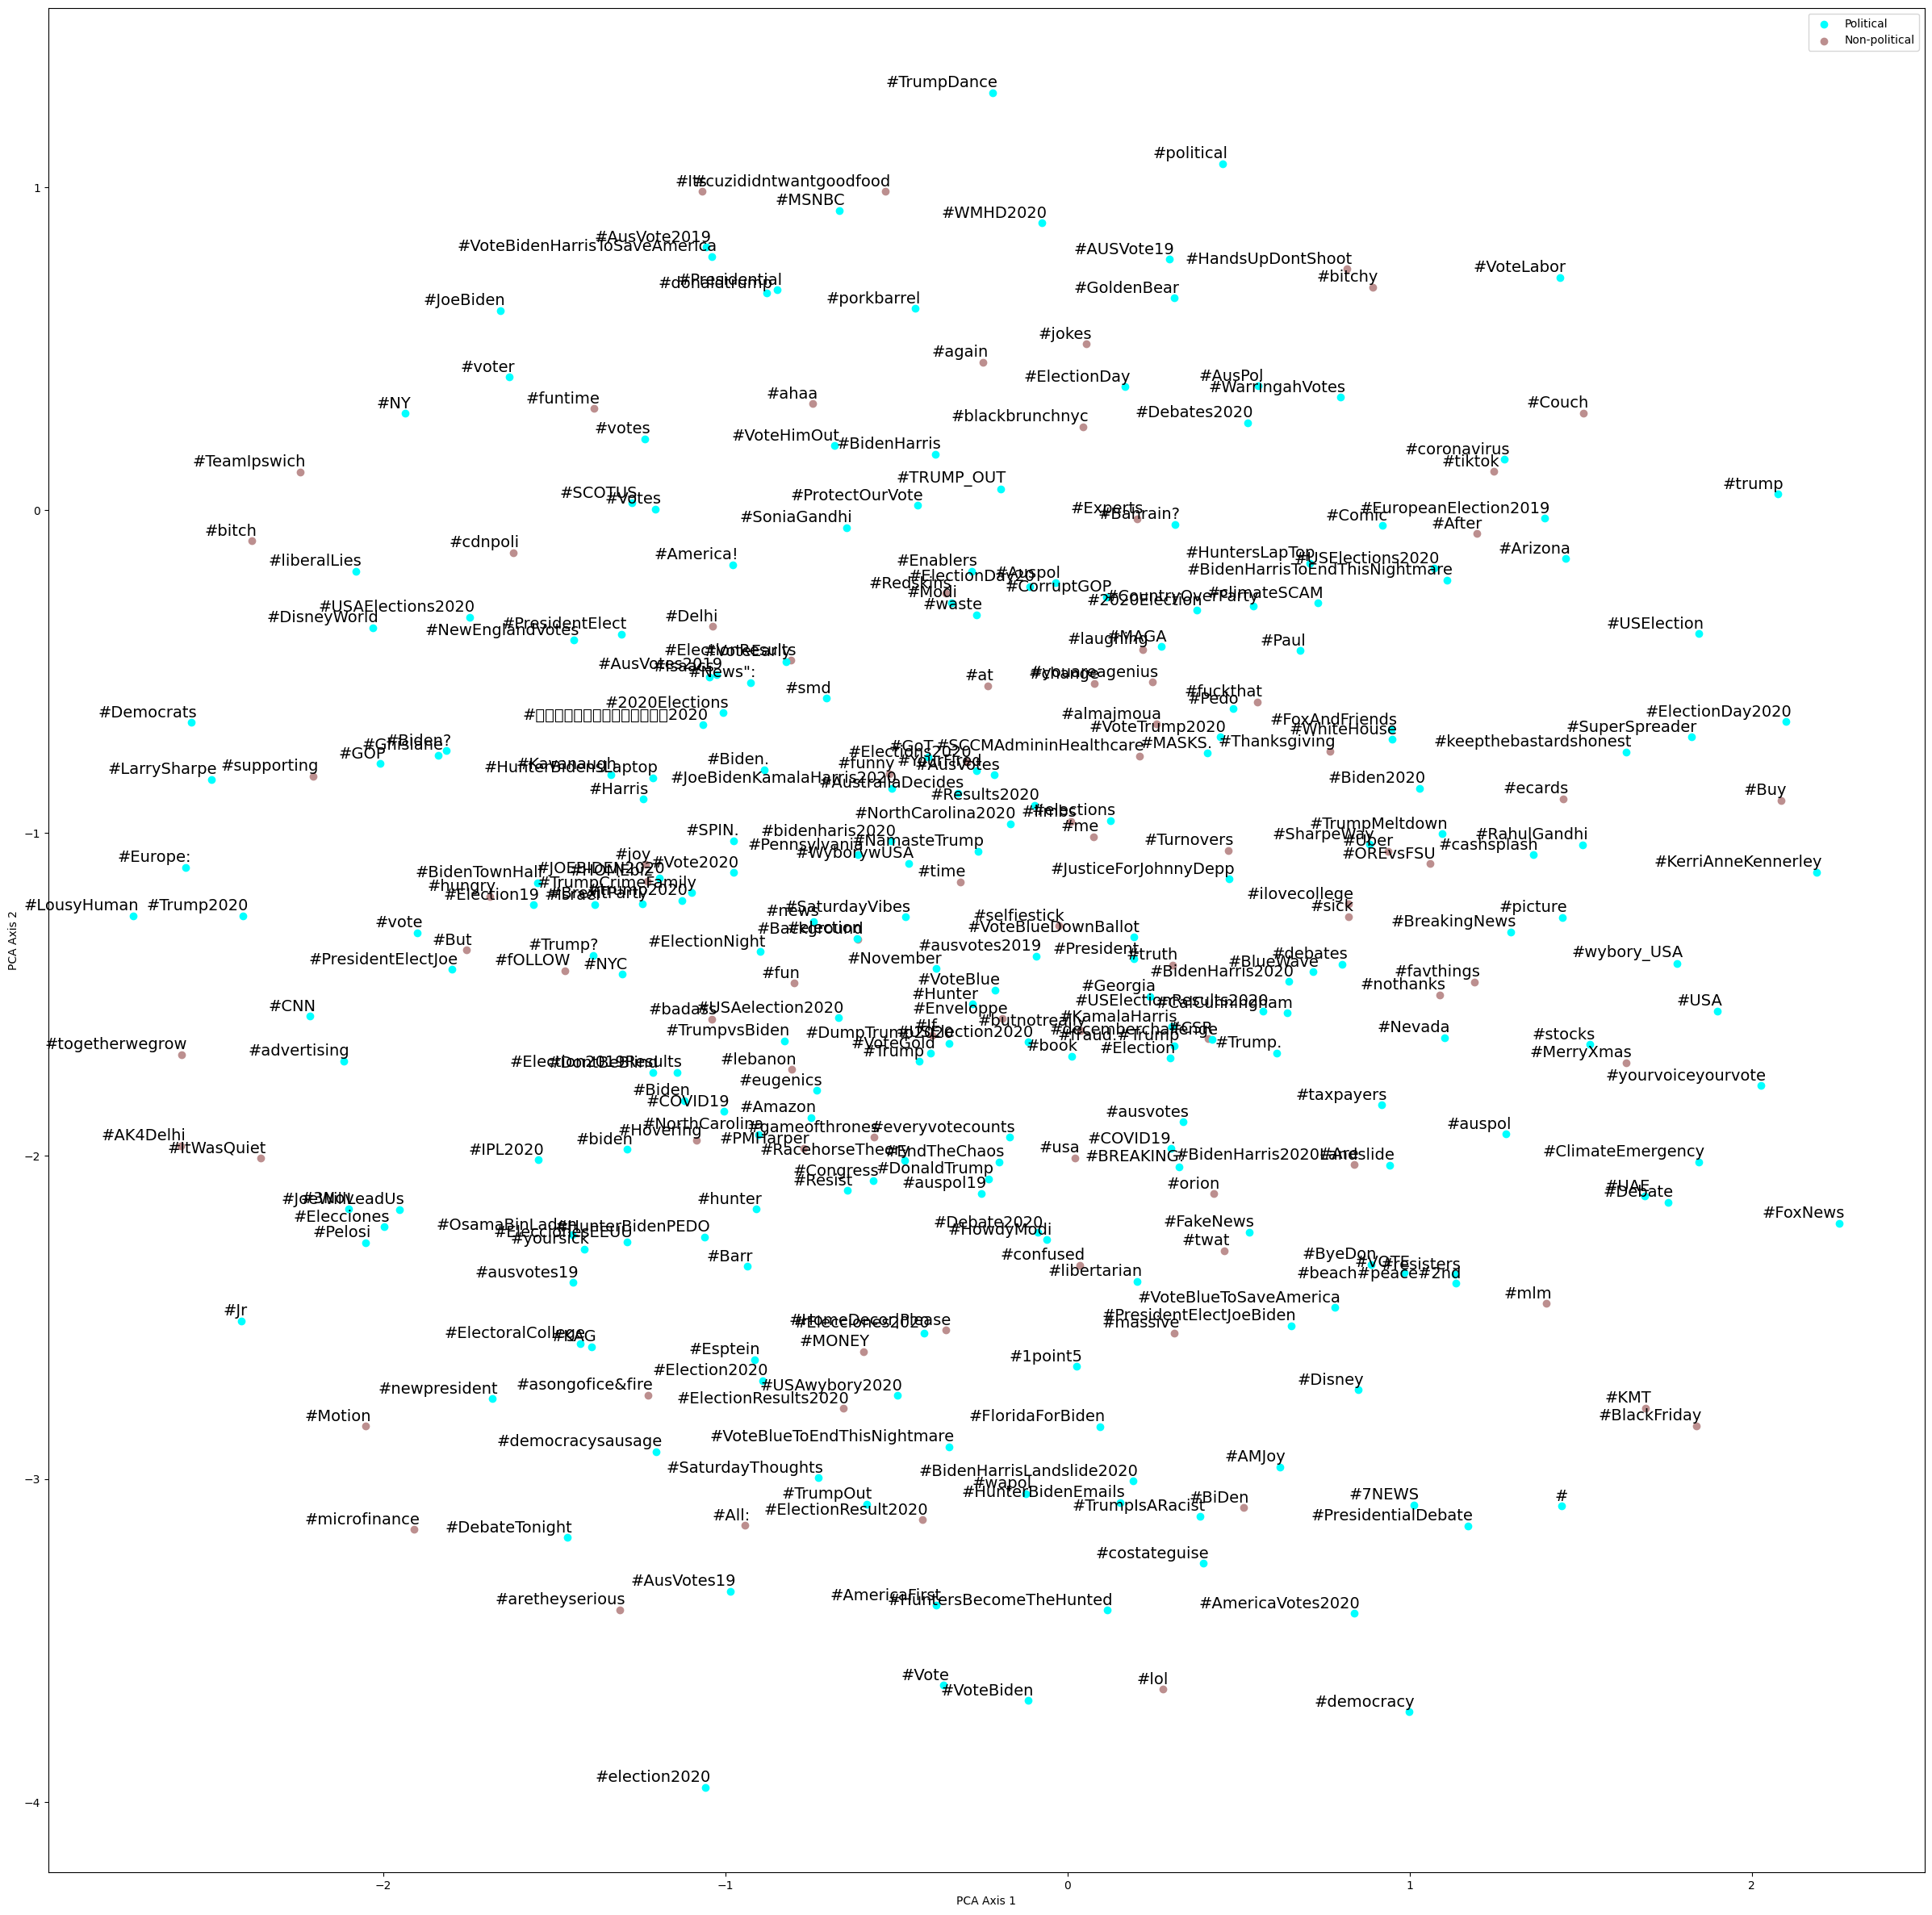

In [47]:
import matplotlib.pyplot as plt
x = []
y = []
colors = {
    0: 'rosybrown',
    1: 'cyan'
}
for value in new_values:
    x.append(value[0])
    y.append(value[1])

plt.figure(figsize=(30, 30))
seen0 = False
seen1 = False
for i in range(len(x)):
    label = 'Political' if preds[i] else 'Non-political'
    if preds[i]:
      label = 'Political'
      if not seen0:
        plt.scatter(x[i],y[i],c=colors[preds[i]], label=label)
        seen0 = True
      else:
        plt.scatter(x[i],y[i],c=colors[preds[i]])
    else:
      label = 'Non-political'
      if not seen1:
        plt.scatter(x[i],y[i],c=colors[preds[i]], label=label)
        seen1 = True
      else:
        plt.scatter(x[i],y[i],c=colors[preds[i]])
    plt.annotate(labels[i],
                  xy=(x[i], y[i]),
                  xytext=(5, 2),
                  textcoords='offset points',
                  ha='right',
                  va='bottom',
                 size=14)
plt.xlabel('PCA Axis 1')
plt.ylabel('PCA Axis 2')
plt.legend()
plt.show()
# tsne_plot(model)